# Medical Image Computing Excercise 3

## Preparation

The following imports are needed:

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

## Feature Selection

### Load Data

The following code loads the data from the attached `XL.csv` file for further processing as a `numpy` structured array. The parameter `names=True` makes the column values addressable by the names given in the first line of the file.

In [2]:
raw_data = np.genfromtxt(fname='XL.csv', delimiter=',', names=True)

Next, convert the last column datatype to integers for better handling. This step is probably not strictly necessary, but makes the distinction between labels and "operative" data clearer.

In [3]:
dtypes = raw_data.dtype.descr
dtypes[-1] = ('Label', np.int32)
raw_data = raw_data.astype(dtypes)

The size of the dataset can be determined by the following commands. `.shape` gives the number of elements the data contains, while `.dtype` shows the number of columns and their datatypes, respectively:

In [4]:
print(f'number of rows: {raw_data.shape[0]} \n'
      f'number of columns: {len(raw_data.dtype)}')

number of rows: 676 
number of columns: 21


As the labels are also a column, the number of features is 20.

Thus to compute the covariance matrix, we need all columns except for the last one. To this end, we first define a function which provides different views on a structured array (to save memory):

In [5]:
def fields_view(arr, fields):
    dtype2 = np.dtype({name:arr.dtype.fields[name] for name in fields})
    return np.ndarray(arr.shape, dtype2, arr, 0, arr.strides)

Using this function and the column descriptor `dtypes` from above, we can create a view of the data without the labels and compute the covariance matrix:

In [6]:
cov_dtypes = []
for dt in dtypes[:-1]:
    cov_dtypes.append(dt[0])

cov_data = fields_view(raw_data, cov_dtypes)
cov_data = np.array(cov_data.tolist())

stdsc = StandardScaler()

X_std = stdsc.fit_transform(cov_data)

cov_mat = np.cov(X_std, rowvar=False, )
print(f'Size of covariant matrix: {cov_mat.shape}')

Size of covariant matrix: (20, 20)


The following code displays the covariant matrix values overlayed on a heatmap showing positive and negative correlation of the different parameters.

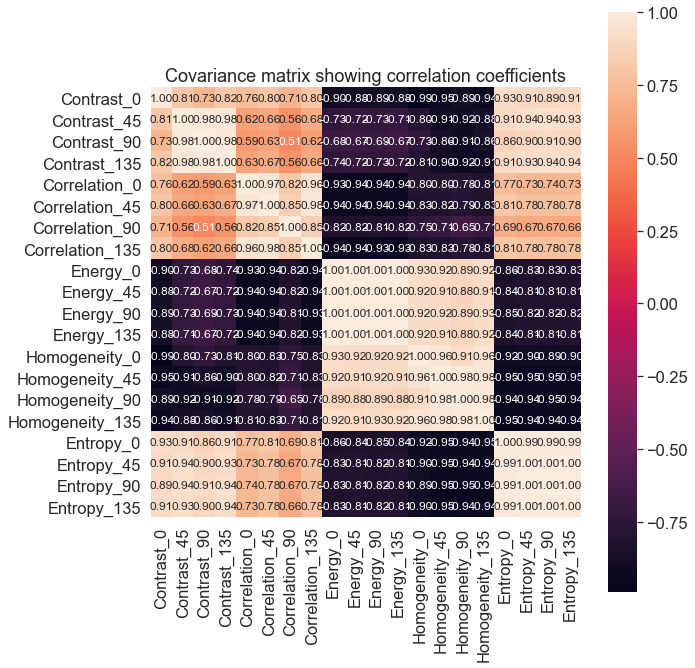

In [7]:
plt.figure(figsize=(10,10))
sns.set(font_scale=1.5)

hm = sns.heatmap(cov_mat,
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 annot_kws={'size': 12},
                 yticklabels=cov_dtypes,
                 xticklabels=cov_dtypes)

plt.title('Covariance matrix showing correlation coefficients')
plt.tight_layout()
plt.show()

### Dimension reduction

Hint: `tolist()` is needed to create a numpy array from a structured array

In [8]:
select_features = ['Contrast_0', 'Correlation_45', 'Correlation_135', 'Energy_0', 'Homogeneity_0', 'Entropy_135']

select_data = fields_view(raw_data, select_features).tolist()

### Split test and training data

...

In [9]:
x_train = np.array(cov_data[52:-52])
x_test = np.array(cov_data[:52])
x_test = np.append(x_test, 
                   np.array(cov_data[-52:]),
                   axis=0)

x1_train = np.array(select_data[52:-52])
x1_test = np.array(select_data[:52])
x1_test = np.append(x1_test, 
                    np.array(select_data[-52:]),
                    axis=0)

In [10]:
print(f'Shape of x_test: {x_test.shape}')
print(f'Shape of x_train: {x_train.shape}')

Shape of x_test: (104, 20)
Shape of x_train: (572, 20)


In [11]:
print(f'Shape of x_test: {x1_test.shape}')
print(f'Shape of x_train: {x1_train.shape}')

Shape of x_test: (104, 6)
Shape of x_train: (572, 6)


As the training and test data sets are all selected by the same indices, the same label data set can be used for both. Retrieving the labels follows the same basic principle as the dimension reduction above.

In [12]:
label_data = np.ravel(fields_view(raw_data, ['Label']).tolist())

y_train = np.array(label_data[52:-52])
y_test = np.array(label_data[:52])
y_test = np.append(y_test,
                   np.array(label_data[-52:]),
                   axis=0)

The resulting list of labels can also be used to count the number of samples per class:

In [13]:
print(f'Training set bincount: {np.bincount(y_train)}')
print(f'Test set bincount:     {np.bincount(y_test)}')

Training set bincount: [  0 143 143 143 143]
Test set bincount:     [ 0 26 26 26 26]


## Classification

### kNN reduced vs. full dataset

Before applying kNN, it is advised to normalize the data.

In [14]:
scaler = StandardScaler()
scaler.fit(x_train)

x_train = scaler.transform(x_train.astype(np.float64))
x_test = scaler.transform(x_test.astype(np.float64))

scaler.fit(x1_train)

x1_train = scaler.transform(x1_train.astype(np.float64))
x1_test = scaler.transform(x1_test.astype(np.float64))

Next, use the training data to generate a model with kNN:

In [15]:
classifier_full = KNeighborsClassifier(n_neighbors=5)
classifier_full.fit(x_train, y_train)

classifier_small = KNeighborsClassifier(n_neighbors=5)
classifier_small.fit(x1_train, y_train)

KNeighborsClassifier()

Create prediction vector

In [16]:
prediction_full = classifier_full.predict(x_test)
prediction_small = classifier_small.predict(x1_test)

Test accuracy with confusion matrix and report:

In [17]:
print('confusion matrix for full dataset:\n', confusion_matrix(y_test, prediction_full), '\n\n')
print('classification report full dataset:\n',classification_report(y_test, prediction_full), '\n\n')

print('confusion matrix for reduced dataset:\n', confusion_matrix(y_test, prediction_small), '\n\n')
print('classification report reduced dataset:\n',classification_report(y_test, prediction_small), '\n\n')

confusion matrix for full dataset:
 [[26  0  0  0]
 [ 0 26  0  0]
 [ 0  0 26  0]
 [ 1  6  0 19]] 


classification report full dataset:
               precision    recall  f1-score   support

           1       0.96      1.00      0.98        26
           2       0.81      1.00      0.90        26
           3       1.00      1.00      1.00        26
           4       1.00      0.73      0.84        26

    accuracy                           0.93       104
   macro avg       0.94      0.93      0.93       104
weighted avg       0.94      0.93      0.93       104
 


confusion matrix for reduced dataset:
 [[25  0  0  1]
 [ 0 26  0  0]
 [ 0  0 25  1]
 [ 1  5  0 20]] 


classification report reduced dataset:
               precision    recall  f1-score   support

           1       0.96      0.96      0.96        26
           2       0.84      1.00      0.91        26
           3       1.00      0.96      0.98        26
           4       0.91      0.77      0.83        26

    accura

Room for discussion ;)

### Random forest

Initiate a random forests with 30, 50 and 100 trees

In [18]:
from sklearn.ensemble import RandomForestClassifier

classifiers = [( '30', RandomForestClassifier(n_estimators=30, oob_score=True)),
               ( '50', RandomForestClassifier(n_estimators=50, oob_score=True)),
               ('100', RandomForestClassifier(n_estimators=100, oob_score=True))]

Train model and predict, then record out-of-bag error.

In [19]:
# baggign errors
ooberror_x = []
ooberror_x1 = []

# feature importance
feat_imp_x = []
feat_imp_x1 = []

# compute for each classifier
for n_est, clf in classifiers:
    clf.fit(x_train, y_train)
    ooberror_x.append((n_est, 1 - clf.oob_score_))
    feat_imp_x.append((n_est, clf.feature_importances_))
    clf.fit(x1_train, y_train)
    ooberror_x1.append((n_est, 1 - clf.oob_score_))
    feat_imp_x1.append((n_est, clf.feature_importances_))

Test accuracy:

In [20]:
print('full dataset\n')
for n_est, result in ooberror_x:
    print(f'trees={n_est}: ooberror={result}')

print('\n\n',
      'reduced dataset\n')
for n_est, result in ooberror_x1:
    print(f'trees={n_est}: ooberror={result}')

full dataset

trees=30: ooberror=0.05944055944055948
trees=50: ooberror=0.054195804195804165
trees=100: ooberror=0.05594405594405594


 reduced dataset

trees=30: ooberror=0.08216783216783219
trees=50: ooberror=0.07167832167832167
trees=100: ooberror=0.06468531468531469


### Analysis and interpretation

...

In [21]:
for n_est, result in feat_imp_x:
    print(f'\n\ntrees={n_est}, feature importance:')
    print(f'Feature\t\t\t Importance rating\n'
          f'------------------------------------------------')
    for i, val in enumerate(result):
        print(f'{cov_dtypes[i]}:\t\t {val}')



trees=30, feature importance:
Feature			 Importance rating
------------------------------------------------
Contrast_0:		 0.008554799149125996
Contrast_45:		 0.02759778253117045
Contrast_90:		 0.043429222134247256
Contrast_135:		 0.008978136996667926
Correlation_0:		 0.05739694848579762
Correlation_45:		 0.07682974838202575
Correlation_90:		 0.11060369712313817
Correlation_135:		 0.11227672828433508
Energy_0:		 0.0804159627905546
Energy_45:		 0.03839499872798479
Energy_90:		 0.07776091605751008
Energy_135:		 0.00977780249727011
Homogeneity_0:		 0.007941958640893147
Homogeneity_45:		 0.05046764297697695
Homogeneity_90:		 0.06104136991941953
Homogeneity_135:		 0.03318709808881546
Entropy_0:		 0.039344451824062626
Entropy_45:		 0.06849064641527298
Entropy_90:		 0.029492215836919477
Entropy_135:		 0.05801787313781179


trees=50, feature importance:
Feature			 Importance rating
------------------------------------------------
Contrast_0:		 0.013328939384228662
Contrast_45:		 0.02655409405

In [22]:
for n_est, result in feat_imp_x1:
    print(f'\n\ntrees={n_est}, feature importance:')
    print(f'Feature\t\t\t Importance rating\n'
          f'------------------------------------------------')
    for i, val in enumerate(result):
        print(f'{select_features[i]}:\t\t {val}')



trees=30, feature importance:
Feature			 Importance rating
------------------------------------------------
Contrast_0:		 0.07199829564643204
Correlation_45:		 0.16627064106788214
Correlation_135:		 0.24350427542793704
Energy_0:		 0.23784229209114002
Homogeneity_0:		 0.039728911949131265
Entropy_135:		 0.24065558381747748


trees=50, feature importance:
Feature			 Importance rating
------------------------------------------------
Contrast_0:		 0.08092821135484468
Correlation_45:		 0.1688357515784772
Correlation_135:		 0.2761481247070027
Energy_0:		 0.2377389132852158
Homogeneity_0:		 0.0659706612527074
Entropy_135:		 0.1703783378217523


trees=100, feature importance:
Feature			 Importance rating
------------------------------------------------
Contrast_0:		 0.08053948312481937
Correlation_45:		 0.1661701426004746
Correlation_135:		 0.2541814220259272
Energy_0:		 0.22844108842567748
Homogeneity_0:		 0.0452230518594407
Entropy_135:		 0.22544481196366084
